# Camera Pose Estimation with OpenCV

### Goal

The goal of this notebook is to estimate the camera pose w.r.t. a reference object of known geometry such as a chessboard.

* Input: intrinsic parameter $K$, an image of a reference object (e.g. chessboard) and its 3D geometry
* Output: camera pose $R, t$ w.r.t. the reference object

Given a set of 2D-3D correspondences, the below solves a Perspective-n-Point (PnP) problem and obtain $R, t$ that satisfy $\tilde{x} \sim K (R|t)\tilde{X}$.


## Libraries

In [1]:
%matplotlib notebook
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pycalib.plot import plotCamera


## Calibration parameters

In [2]:
# Chessboard configuration
rows = 7   # Number of corners (not cells) in row
cols = 10  # Number of corners (not cells) in column
size = 160 # Physical size of a cell (the distance between neighrboring corners). Any positive number works.

# Input images capturing the chessboard above
input_file = '../data/chessboard/00000000.jpg'

# plotCamera() config
plot_mode   = 0    # 0: fixed camera / moving chessboard,  1: fixed chessboard, moving camera
plot_range  = 4000 # target volume [-plot_range:plot_range]
camera_size = 100  # size of the camera in plot

## 3D positions of the chess corners in WCS

In [3]:
X_W = np.empty([rows * cols, 3], dtype=np.float32)
for i_row in range(0, rows):
    for i_col in range(0, cols):
        X_W[i_row*cols+i_col] = np.array([size*i_col, size*i_row, 0], dtype=np.float32)
print(X_W)

[[   0.    0.    0.]
 [ 160.    0.    0.]
 [ 320.    0.    0.]
 [ 480.    0.    0.]
 [ 640.    0.    0.]
 [ 800.    0.    0.]
 [ 960.    0.    0.]
 [1120.    0.    0.]
 [1280.    0.    0.]
 [1440.    0.    0.]
 [   0.  160.    0.]
 [ 160.  160.    0.]
 [ 320.  160.    0.]
 [ 480.  160.    0.]
 [ 640.  160.    0.]
 [ 800.  160.    0.]
 [ 960.  160.    0.]
 [1120.  160.    0.]
 [1280.  160.    0.]
 [1440.  160.    0.]
 [   0.  320.    0.]
 [ 160.  320.    0.]
 [ 320.  320.    0.]
 [ 480.  320.    0.]
 [ 640.  320.    0.]
 [ 800.  320.    0.]
 [ 960.  320.    0.]
 [1120.  320.    0.]
 [1280.  320.    0.]
 [1440.  320.    0.]
 [   0.  480.    0.]
 [ 160.  480.    0.]
 [ 320.  480.    0.]
 [ 480.  480.    0.]
 [ 640.  480.    0.]
 [ 800.  480.    0.]
 [ 960.  480.    0.]
 [1120.  480.    0.]
 [1280.  480.    0.]
 [1440.  480.    0.]
 [   0.  640.    0.]
 [ 160.  640.    0.]
 [ 320.  640.    0.]
 [ 480.  640.    0.]
 [ 640.  640.    0.]
 [ 800.  640.    0.]
 [ 960.  640.    0.]
 [1120.  640.

## Intrinsic Parameter

Use `incalib_chess.ipynb` to get the intrinsic parameter.

In [7]:
K =  np.array([[1.32931637e+03, 0.00000000e+00, 9.57857318e+02],
 [0.00000000e+00, 1.32931637e+03, 5.47353253e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
d = np.array([[ 0.0052289,  -0.01161532,  0.0029297,   0.00017352,  0.0003208 ]])

print("Intrinsic parameter K = ", K)
print("Distortion parameters d = (k1, k2, p1, p2, k3) = ", d)


Intrinsic parameter K =  [[1.32931637e+03 0.00000000e+00 9.57857318e+02]
 [0.00000000e+00 1.32931637e+03 5.47353253e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion parameters d = (k1, k2, p1, p2, k3) =  [[ 0.0052289  -0.01161532  0.0029297   0.00017352  0.0003208 ]]


## 2D chessconrer detection and PnP

<IPython.core.display.Javascript object>


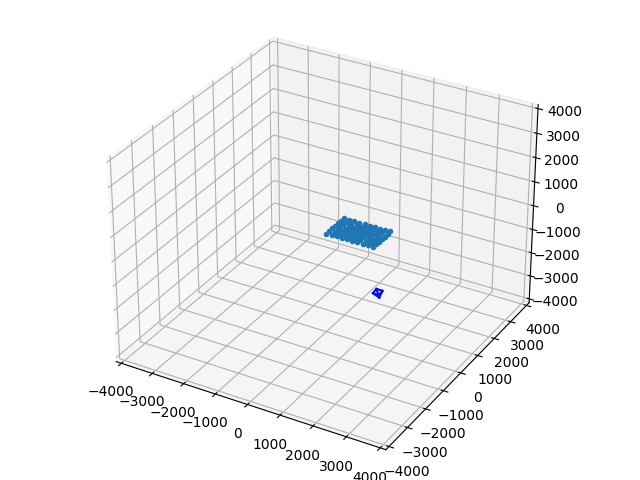

In [5]:
img = cv2.imread(input_file, cv2.IMREAD_GRAYSCALE)        # Image
found, x_I = cv2.findChessboardCorners(img, (cols, rows)) # Find chess corners

if found:
    term = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_COUNT,30,0.1) 
    x_I_sub = cv2.cornerSubPix(img, x_I, (5,5), (-1,-1), term) # subpixel refinment

    ret, rvec, tvec = cv2.solvePnP(X_W, x_I, K, d) # Solve PnP

    # Plot
    fig_ex = plt.figure()
    ax_ex = Axes3D(fig_ex, auto_add_to_figure=False)
    fig_ex.add_axes(ax_ex)

    ax_ex.set_xlim(-plot_range, plot_range)
    ax_ex.set_ylim(-plot_range, plot_range)
    ax_ex.set_zlim(-plot_range, plot_range)

    R_w2c = cv2.Rodrigues(rvec)[0]  # PnP returns R, t satisfying Xc = R X_w + t
    R_c2w = np.linalg.inv(R_w2c)    #　Camera pose in WCS
    t_c2w = -R_c2w.dot(tvec).reshape((1,3)) # Camera position in WCS
    
    plotCamera(ax_ex, R_c2w, t_c2w, "b", camera_size)

    ax_ex.plot(X_W[:,0], X_W[:,1], X_W[:,2], ".")
    plt.show()

## Exercises

1. Try **ChArUco** patterns instead of chessboards.
   * [Detection of ChArUco Corners](https://docs.opencv.org/master/df/d4a/tutorial_charuco_detection.html)
   * Try with an image having an occluding object on the board.
